In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import scipy.stats
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
import os
if not os.path.exists("images"):
    os.mkdir("images")
import kaleido 
import plotly.graph_objects as go
import math
from scipy import stats
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML


In [2]:
pip install kaleidoscope

  Obtaining dependency information for kaleidoscope from https://files.pythonhosted.org/packages/3a/d3/285470ffe29a919ccab9dab28be48c1db5a411500f8b5d9306315645ea0f/kaleidoscope-0.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/54.4 kB ? eta -:--:--
   ---------------------- ----------------- 30.7/54.4 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 54.4/54.4 kB 711.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --upgrade "kaleido==0.1.*"

  Obtaining dependency information for kaleido==0.1.* from https://files.pythonhosted.org/packages/41/90/51523adbedc808e03271c7448fd71da1660cc02603eaaf10b9ab4f102146/kaleido-0.1.0.post1-py2.py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/56.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/56.0 MB 5.0 MB/s eta 0:00:12
   ---------------------------------------- 0.3/56.0 MB 4.1 MB/s eta 0:00:14
   ---------------------------------------- 0.6/56.0 MB 5.1 MB/s eta 0:00:11
    --------------------------------------- 0.9/56.0 MB 5.4 MB/s eta 0:00:11
    --------------------------------------- 1.1/56.0 MB 5.1 MB/s eta 0:00:11
    --------------------------------------- 1.3/56.0 MB 5.2 MB/s eta 0:00:11
   - -------------------------------------- 1.6/56.0 MB 5.1 MB/s eta 0:00:11
   - -------------------------------------- 2.0/56.0 MB 5.7 MB/s eta 0:00:10
   - -------------------------------------- 2.1/56.0 MB 5.5 MB/s eta 0:00:10
   - ----------

### Import Ames Housing Data

In [54]:
housing = pd.read_csv('dataframes/Ames_HousePrice.csv', index_col=0)
housing = housing.reset_index(drop = True)

# deletes duplicate point 
housing = housing.drop_duplicates()

### Visualize sale price/log sale price  

In [10]:
from plotly.subplots import make_subplots
from scipy.stats import skew
saleprice_skewness = skew(housing.SalePrice)
log_saleprice_skewness = skew(np.log(housing.SalePrice))

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(
    x=housing.SalePrice,
    name='Sale Price ($)',
    nbinsx=50,
    opacity=0.7,
    marker_color='blue', showlegend= False),
              row=1, col=1)

# Create the histogram for LogSalePrice
fig.add_trace(go.Histogram(
    x=np.log(housing.SalePrice),
    name='Log Sale Price',
    nbinsx=50,
    opacity=0.5,
    marker_color='red', showlegend= False),
              row=1, col=2)

fig.update_layout(
    title=dict(y=0.85),
    title_text='Histograms of Sale Prices and Log of Sale Prices',
    title_x = .5,
    height=400,
    template='plotly'
)

fig.add_annotation(
    xref="paper", yref="paper",
    x=500000, y=325,
    text=f"Skewness: {saleprice_skewness:.2f}",
    showarrow=False,
    row=1, col=1
)
fig.add_annotation(
    xref="paper", yref="paper",
    x=10.5, y=225,
    text=f"Skewness: {log_saleprice_skewness:.2f}",
    showarrow=False,
    row=1, col=2
)

fig.update_xaxes(title_text='Sale Price ($)',title_standoff= 0, row=1, col=1)
fig.update_xaxes(title_text='Log of Sale Price ($)',title_standoff= 0, row=1, col=2)

# Show plot
fig.show()

#fig.write_image("price_vs_log.svg") 

### Divide data into numerical and categorical columns for EDA

In [55]:
from sklearn.compose import make_column_selector as selector
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(housing)
categorical_columns = categorical_columns_selector(housing)

### How do the categorical and numerical variables correlate with sale price 

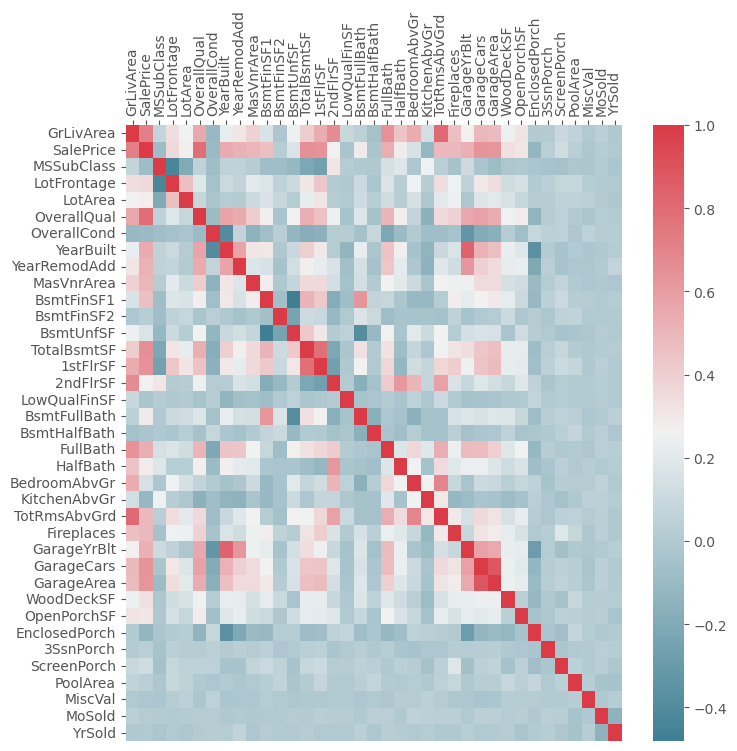

In [61]:
# High correlation between GrLivArea/TotalRmsAbvGrd, YearBuilt/GarageYrBlt, 
# GarageArea/GarageCars, 1stFlrSF/TotalBsmtSF
# important to note for preprocessing and MLR
corr = housing[numerical_columns].corr()
corr = corr.drop('PID')
corr = corr.drop(columns=['PID'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

<Axes: xlabel='SalePrice', ylabel='index'>

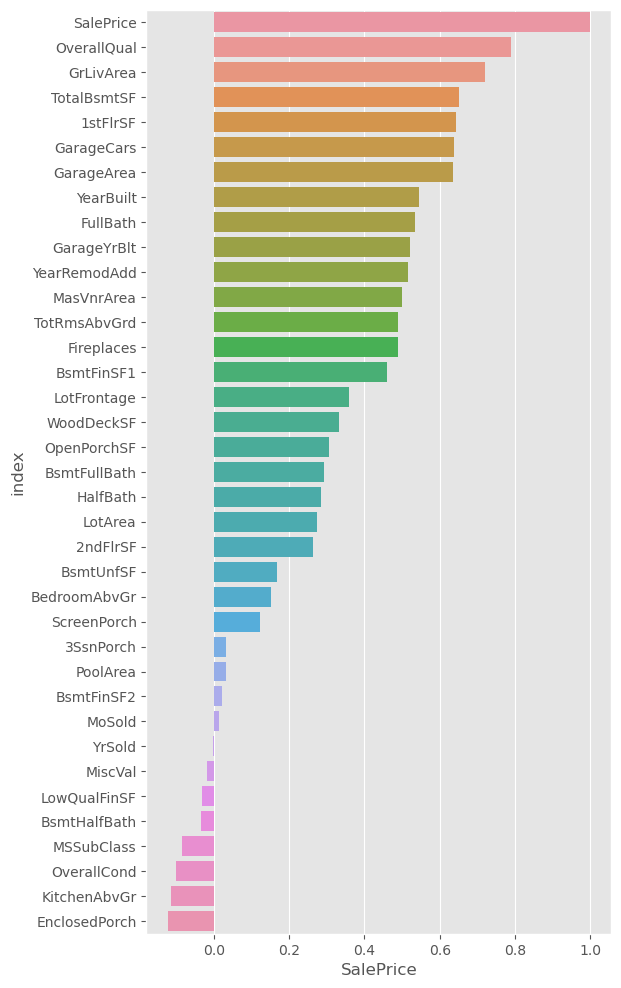

In [63]:
# Highest correlation with SalePrice are OverallQual and GrLivArea 
corr = corr.sort_values('SalePrice', ascending=False)
corr = corr.reset_index()

plt.figure(figsize=(6,12))
sns.barplot(x = 'SalePrice', y = 'index', data = corr)


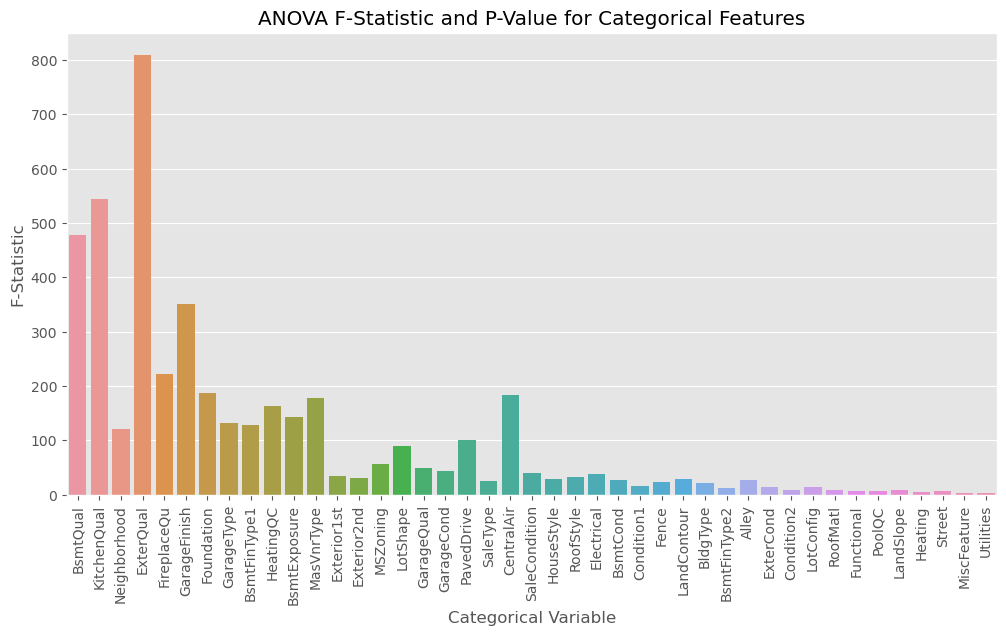

In [85]:
# Sorted by decreasing p-value, the bar is showing the f-statistic 
# BsmtQual, KitchenQual, Neighborhood, and ExterQual all have a 
# p-value of 0, all varaibles have an f-statistic greater than 1 
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
corr = housing[categorical_columns]
corr = corr.fillna('none')
corr = enc.fit_transform(corr)
enc.get_feature_names_out

housing[categorical_columns] = housing[categorical_columns].fillna('Missing')

anova = {'feature':[], 'f':[], 'p':[]}
for cat in categorical_columns:
    group_prices = []
    for group in housing[cat].unique():
        group_prices.append(housing[housing[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', ascending= True, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x='feature', y= 'f', data=anova)
plt.xticks(rotation=90)

plt.xlabel('Categorical Variable')
plt.ylabel('F-Statistic')
plt.title('ANOVA F-Statistic and P-Value for Categorical Features')


plt.show()
#plt.show()

### Visualize highest correlated varaibles with sale price 

In [66]:
fig = px.scatter(housing, x= 'GrLivArea', y = 'SalePrice', color = 'OverallQual',
                 title='Living Area vs. Sale Price',
                 labels={'GrLivArea': 'Above Ground Living Area (square feet)', 
                         'SalePrice': 'Sale Price ($)',
                        'OverallQual': ''},
                hover_data= ['SaleCondition'],
                 color_continuous_scale='Turbo')

fig.update_layout(
    title=dict(y=0.9))

# Add custom annotation for the legend title
fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)

fig.show()

In [28]:
fig = px.box(housing, x='OverallQual', y='SalePrice', points="all",
             title='Overall Quality vs. Sale Price',
             labels={'OverallQual': 'Overall Quality', 'SalePrice': 'Sale Price ($)'})
fig.update_layout(
    title=dict(y=0.85),
    height=500,
    width=800)

fig.show()

In [26]:
fig = px.box(housing, x='ExterQual', y='SalePrice', points="all",
             title='External Quality vs. Sale Price',
             labels={'ExterQual': 'External Quality', 'SalePrice': 'Sale Price ($)'},
             category_orders={'ExterQual': ['Fa', 'TA', 'Gd', 'Ex']})

fig.update_layout(
    title=dict(y=0.85),
    height=500,
    width=800)

fig.show()

In [27]:
fig = px.box(housing, x='KitchenQual', y='SalePrice', points="all",
             title='Kitchen Quality vs. Sale Price',
             labels={'KitchenQual': 'Kitchen Quality', 'SalePrice': 'Sale Price ($)'},
             category_orders={'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex']})

fig.update_layout(
    title=dict(y=0.85),
    height=500,
    width=800)

fig.show()

In [74]:
fig = px.box(housing, x='BsmtQual', y='SalePrice', points="all",
             title='Basement Quality vs. Sale Price',
             labels={'BsmtQual': 'Basement Quality', 'SalePrice': 'Sale Price ($)'},
             category_orders={'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex']})
fig.update_layout(
    title=dict(y=0.85),
    height=500,
    width=800)

fig.show()

### Visualize how neighborhoods vs. sale price 

In [86]:
fig = px.scatter(
    x=housing.Neighborhood, 
    y= housing.SalePrice, 
    #color = df_normal_quality.SalePrice,
    color = housing.OverallQual,
    labels={'x': 'Neighborhood', 
            'y': 'Sale Price ($)',
           'color': ''},
    title='Neighborhood vs SalePrice',
    color_continuous_scale='Turbo')



fig.update_layout(
    title=dict(y=0.9))

# Add custom annotation for the legend title
fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)
# Show the plot
fig.show()

### Visualize how the prices of home with and without garages compare 

In [30]:
print('no garage', housing.loc[housing.GarageYrBlt.isnull()].SalePrice.mean())
print('garage', housing.loc[housing.GarageYrBlt.notnull()].SalePrice.mean())

no garage 106814.6046511628
garage 181804.38530612245


In [36]:
# most home built at the same time as the Garage 
# Create the histogram
fig = px.histogram(
    housing, 
    x= housing.YearBuilt - housing.GarageYrBlt,
    nbins=30,  # Number of bins for the histogram
    title='Difference Between YearBuilt and GarageYrBlt',
    labels={'Year_Garage_Diff': 'Year Built - Garage Year Built'}
)

# Show the plot
fig.show()

In [33]:
# Garage Year Built highly correlation with the year the home is built 
fig = px.scatter(
    x=housing.YearBuilt, 
    y= housing.GarageYrBlt, 
    labels={'x': 'Year Home Built', 'y': 'Year Garage Built'},
    title='Year Home Built vs. Year Garage Built'
)

# Show the plot
fig.show()

In [34]:
# The difference in time the garage and home were built say very little about the sale price
fig = px.scatter(
    x=housing.YearBuilt - housing.GarageYrBlt, 
    y= housing.SalePrice, 
    labels={'x': 'Garage Year Built', 'y': 'Sale Price ($)'},
    title="Garage Year Built vs. Sale Price <br><sup> For garages not built at the same time as the home</sup>",
)

fig.show()

In [32]:
# Create a scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = housing.loc[housing.GarageYrBlt.notnull()].YearBuilt,  # Using index as x-axis
    y = housing.loc[housing.GarageYrBlt.notnull()].SalePrice,
    mode='markers',
    name='Garage: mean price = $181804',
    marker=dict(color='green'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x = housing.loc[housing.GarageYrBlt.isnull()].YearBuilt,  # Using index as x-axis
    y = housing.loc[housing.GarageYrBlt.isnull()].SalePrice,
    mode='markers',
    name='No Garage: mean price = $106815',
    marker=dict(color='blue'),
    showlegend=True
))

# Update layout

fig.update_layout(
    title="Sale Price of Homes with vs. without Garages",
    xaxis_title='Year Home Built',
    yaxis_title='Sale Price ($)',
    template='plotly',
    height=600,
    width=800,
    legend=dict(
        x=.05,
        y=.95,
        traceorder='normal',
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.5)',
        borderwidth=1
    )
)

fig.update_layout(
    title=dict(y=0.9))
# Show plot
fig.show()


### Visual pool area vs. sale price

In [82]:
print('pool', housing.loc[housing.PoolArea != 0].SalePrice.mean())
print('no pool', housing.loc[housing.PoolArea == 0].SalePrice.mean())

pool 255944.44444444444
no pool 177780.67237354085


In [106]:
# very few homes have pools 
housing.PoolArea.value_counts()

PoolArea
0      2570
144       1
800       1
519       1
444       1
648       1
228       1
561       1
576       1
368       1
Name: count, dtype: int64

In [39]:
# the size of the pool has little correlation with sale price)
fig = px.scatter(
    x= housing.PoolArea, 
    y= housing.SalePrice, 
    labels={'x': 'Pool Area (square feet)', 
            'y': 'Sale Price ($)'},
    title='Pool Area vs Sale Price'
)

fig.update_layout(
    title=dict(y=0.9))

# Show the plot
fig.show()

# PreProcessing

### Con

In [ ]:
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
# reset index so there is only one number associated with each house
housing = housing.reset_index(drop = True)

# deletes duplicate point 
housing = housing.drop_duplicates()

#Convert some numerical variables to categorical 
housing.MSSubClass = housing.MSSubClass.apply(lambda x: str(x))
housing.MoSold = housing.MoSold.apply(lambda x: str(x))
housing.YrSold = housing.YrSold.apply(lambda x: str(x))

# Alley
housing.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)

# Lot Shape
housing.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)

# Land Contour
housing.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)

# Utilities
housing.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)

# Land Slope..idk if I'm going to inlude this 
# further investigation there is correlation ..severe slope = more expensiveaaa
housing.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

# Exterior Quality
housing.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Exterior Condition
housing.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
housing.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Condition
housing.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
housing.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
housing.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Finished Basement 2 Rating
housing.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
housing.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
housing.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Home functionality
housing.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)

# Fireplace Quality
housing.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
housing.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

# Garage Quality
housing.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Condition
housing.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Paved Driveway
housing.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)

# Pool Quality
housing.PoolQC.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# for the converted features fill in nulls with 0
converted_features = ['Alley','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond',
        'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
        'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
        'GarageCond','PavedDrive','PoolQC']
housing[converted_features] = housing[converted_features].fillna(0)

# some categorical nulls will be filled in with none
missing_categorical_none = ['MasVnrType', 'GarageType', 'Fence', 'MiscFeature']  
housing[missing_categorical_none] = housing[missing_categorical_none].fillna('NO')

# electrical nulls is filled in with the most common value
housing.Electrical = housing.Electrical.fillna('SBrkr')

# most null numericals are filled in with 0
missing_numerical = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                                'GarageCars', 'GarageArea']
housing[missing_numerical] = housing[missing_numerical].fillna(0)

# missing lot frontage is filled in with the mean ratio of lot frontage to lot area 
proportion = (housing.LotFrontage/housing.LotArea).mean()
housing.LotFrontage.fillna((housing.LotArea * proportion), inplace=True)

# Pool area is changed to yes/no pool 
f = lambda x: 'yes' if x>0 else 'no'
housing.PoolArea = housing.PoolArea.map(f)
housing = housing.rename(columns={"PoolArea": "PoolYN"})

# Garage year is changed to yes/no garage
housing.GarageYrBlt = housing.GarageYrBlt.fillna(0)
housing = housing.rename(columns={"GarageYrBlt": "GarageYN"})
housing.GarageYN = housing.GarageYN.map(f)

# create a variable for how many bathrooms are in the home 
housing['Bathrooms'] = housing.BsmtFullBath + (.5 *housing.BsmtHalfBath) + housing.FullBath + (.5 *housing.HalfBath)

# drop MiscFeature it has very little information 
housing = housing.drop(['MiscFeature', 'MiscVal'], axis =1).copy()

#drop the one major outlier (Living area 4676 and sale price of 184750)
# I chose to leave the other large house in due to it following the general trend
housing.drop(309, inplace=True)


### Remove certain outlier groups before scaling features

In [ ]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

df_unscaled = housing.copy()
df_unscaled.to_csv('df_unscaled.csv')

df_normal_unscaled = df_unscaled.copy()
index_all_normal = df_unscaled[df_unscaled['SaleCondition'] != 'Normal'].index
df_normal_unscaled.drop(index_all_normal, inplace = True)
df_normal_unscaled.to_csv('df_normal_unscaled.csv')

quality = list((np.array(range(1,11)))**2)
indexes = []

for qual in quality:
    outliers = find_outliers_IQR(df_normal_quality_unscaled.loc[df_normal_quality_unscaled.OverallQual == qual].SalePrice)
    indexes.extend(list(outliers.index))
    
df_normal_quality_unscaled.drop(indexes, inplace=True)
df_normal_quality_unscaled.to_csv('df_normal_quality_unscaled.csv')

### Scaling the highly correlated quality scores improves linear regression

In [ ]:
# the relationships among SalesPrice and OverallQual, KitchenQual, and ExterQual are exponential
housing.OverallQual = (housing.OverallQual) ** 2
housing.KitchenQual = (housing.KitchenQual)**3
housing.ExterQual = (housing.ExterQual)**3

# call it df
df = housing.copy()

### Outliers

In [ ]:
# remove all outliers 
df_all = df.copy()
outliers = find_outliers_IQR(df_all.SalePrice)
indexes = list(outliers.index)
df_all.drop(indexes, inplace=True)
df_all.to_csv('df_all.csv')


# remove all non-normal sales 
df_all_normal = df.copy()
index_all_normal = df_all_normal[df_all_normal['SaleCondition'] != 'Normal'].index
df_all_normal.drop(index_all_normal, inplace = True)
df_all_normal.to_csv('df_all_normal.csv')


# remove Family, AdjLand, and Alloca sales 
df_faa = df.copy()
index_faa = df_faa[(df_faa['SaleCondition'] == 'Family') | 
                               (df_faa['SaleCondition'] == 'AdjLand') |
                               (df_faa['SaleCondition'] == 'Alloca')].index
df_faa.drop(index_faa, inplace = True)
df_faa.SaleCondition.value_counts()
df_faa.to_csv('df_faa.csv')


# remove all non-normal sales and outliers within each quality group 
df_normal_quality = df_all_normal.copy()

quality = list((np.array(range(1,11)))**2)
indexes = []

for qual in quality:
    outliers = find_outliers_IQR(df_normal_quality.loc[df_normal_quality.OverallQual == qual].SalePrice)
    indexes.extend(list(outliers.index))
    
df_normal_quality.drop(indexes, inplace=True)
df_normal_quality.to_csv('df_normal_quality.csv')


# remove all outliers with quality group 
df_quality = df.copy()

quality = list((np.array(range(1,11)))**2)
indexes = []

for qual in quality:
    outliers = find_outliers_IQR(df_quality.loc[df_quality.OverallQual == qual].SalePrice)
    indexes.extend(list(outliers.index))
    
df_quality.drop(indexes, inplace=True)
df_quality.to_csv('df_quality.csv')

# remove all outliers within quality groups then faa groups
df_some_quality = df_quality.copy()

index_ = df_some_quality[(df_some_quality['SaleCondition'] == 'Family') | 
                               (df_some_quality['SaleCondition'] == 'AdjLand') |
                               (df_some_quality['SaleCondition'] == 'Alloca')].index
df_some_quality.drop(index_, inplace = True)
df_some_quality.SaleCondition.value_counts()
df_some_quality.to_csv('df_some_quality.csv')

### wait on these 

In [ ]:
# # remove all points that are outliers in sales price and living area grouped by quality
# df_
# quality = list((np.array(range(1,11)))**2)
# indexes = []

# for qual in quality:
#     a= find_outliers_IQR(df_quality.loc[df_quality.OverallQual == qual].SalePrice)
#     b = find_outliers_IQR(df_quality.loc[df_quality.OverallQual == qual].GrLivArea)
#     a = list(a.index)
#     b = list(b.index)
#     c = set(a) & set(b)
#     indexes.extend(c)
    
# indexes

In [ ]:
# df_
# quality = list((np.array(range(1,11)))**2)
# indexes = []

# for qual in quality:
#     a= find_outliers_IQR(df_quality.loc[df_quality.OverallQual == qual].SalePrice)
#     b = find_outliers_IQR(df_quality.loc[df_quality.OverallQual == qual].GrLivArea)
#     a = list(a.index)
#     b = list(b.index)
#     c = set(a) & set(b)
#     indexes.extend(c)
    
# indexes

In [ ]:
# remove all non normal sales then remove any outlier in sales price 

In [ ]:
fig = px.scatter(
    x=df_normal_quality.Neighborhood, 
    y= df_normal_quality.SalePrice, 
    #color = df_normal_quality.SalePrice,
    color = np.sqrt(df_normal_quality.OverallQual),
    labels={'x': 'Neighborhood', 'y': 'Living Area in Square Feet'},
    title='Neighborhood vs Living Area'
)

# Show the plot
fig.show()